# Tuning and Optimizing Neural Networks - Lab

## Introduction

Now that we've discussed some regularization, initialization and optimization techniques, its time to synthesize those concepts into a cohesive modelling pipeline.  

With this pipeline, yoiu will not only fit an initial model but will also attempt to set various hyperparameters for regularization techniques. Your final model selection will pertain to the test metrics across these models. This will more naturally simulate a problem you might be faced with in practice, and the various modelling decisions you are apt to encounter along the way.  

Recall that our end objective is to achieve a balance between overfitting and underfitting. We've discussed the bias variance tradeoff, and the role of regularization in order to reduce overfitting on training data and improving generalization to new cases. Common frameworks for such a procedure include train/validate/test methodology when data is plentiful, and K-folds cross-validation for smaller, more limited datasets. In this lab, you'll perform the latter, as the dataset in question is fairly limited. 

## Objectives

You will be able to:

* Implement a K-folds cross validation modelling pipeline
* Apply normalization as a preprocessing technique
* Apply regularization techniques to improve your model's generalization
* Choose an appropriate optimization strategy 

## Loading the Data

In [1]:
#Your code here; load and preview the dataset
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras import layers

import time
import datetime

start = datetime.datetime.now()


Using TensorFlow backend.


In [2]:
data = pd.read_csv("loan_final.csv", header=0)
data = data.dropna()

print(data.shape)

data.head()

(41394, 16)


,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,total_acc,total_pymnt,application_type
0,5000.0,4975.0,36 months,10.65%,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,AZ,9.0,5863.155187,Individual
1,2500.0,2500.0,60 months,15.27%,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,GA,4.0,1014.530000,Individual
2,2400.0,2400.0,36 months,15.96%,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,IL,10.0,3005.666844,Individual
3,10000.0,10000.0,36 months,13.49%,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,CA,37.0,12231.890000,Individual
4,3000.0,3000.0,60 months,12.69%,67.79,B,1 year,RENT,80000.0,Source Verified,Fully Paid,other,OR,38.0,4066.908161,Individual


In [3]:
data.isna().sum()

loan_amnt              0
funded_amnt_inv        0
term                   0
int_rate               0
installment            0
grade                  0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
loan_status            0
purpose                0
addr_state             0
total_acc              0
total_pymnt            0
application_type       0
dtype: int64

## Defining the Problem

Set up the problem by defining X and Y. 

For this problem use the following variables for X:
* loan_amnt
* home_ownership
* funded_amnt_inv
* verification_status
* emp_length
* installment
* annual_inc

Be sure to use dummy variables for categorical variables and to normalize numerical quanitities. Be sure to also remove any rows with null data.  

For Y, we are looking to build a model to predict the total payment received for a loan.

In [4]:
# Your code here; appropriately define X and Y using dummy variables and normalization for preprocessing.

# numerical features
X0 = data["loan_amnt"]
X1 = data["funded_amnt_inv"]
X2 = data["installment"]
X3 = data["annual_inc"]

# standardized inputs
X0= (X0-np.mean(X0))/(np.std(X0))
X1= (X1-np.mean(X1))/(np.std(X1))
X2= (X2-np.mean(X2))/(np.std(X2))
X3= (X3-np.mean(X3))/(np.std(X3))

#categorical features
dummy_ver = pd.get_dummies(data['verification_status'])
dummy_home = pd.get_dummies(data['home_ownership'])
dummy_emp = pd.get_dummies(data['emp_length'])

X = pd.concat([X0, X1, X2, X3, dummy_ver, dummy_home, dummy_emp], axis=1)
# X = X.dropna()
y = data["total_pymnt"]
y = (y-np.mean(y))/np.std(y)

print(np.shape(X))


(41394, 23)


In [5]:
X.isna().sum()

loan_amnt          0
funded_amnt_inv    0
installment        0
annual_inc         0
Not Verified       0
Source Verified    0
Verified           0
MORTGAGE           0
NONE               0
OTHER              0
OWN                0
RENT               0
1 year             0
10+ years          0
2 years            0
3 years            0
4 years            0
5 years            0
6 years            0
7 years            0
8 years            0
9 years            0
< 1 year           0
dtype: int64

## Generating a Hold Out Test Set

While we will be using K-fold cross validation to select an optimal model, we still want a final hold out test set that is completely independent of any modelling decisions. As such, pull out a sample of 10% of the total available data. For consistency of results, use random seed 123. 

In [6]:
# Your code here; generate a hold out test set for final model evaluation. Use random seed 123.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)  

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.head()

(37254, 23) (4140, 23) (37254,) (4140,)


,loan_amnt,funded_amnt_inv,installment,annual_inc,Not Verified,Source Verified,Verified,MORTGAGE,NONE,OTHER,...,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
24882,0.112849,0.021326,-0.286460,0.189661,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
5723,-0.669251,-0.559691,-0.587677,-0.151157,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32465,0.841010,1.008356,1.374322,0.468512,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
34510,-0.831064,-0.727696,-0.806909,-0.306075,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
9396,0.921917,1.092359,1.162835,0.158677,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Defining a K-fold Cross Validation Methodology

Now that your have a complete holdout test set, write a function that takes in the remaining data and performs k-folds cross validation given a model object. Be sure your function returns performance metrics regarding the training and validation sets.

In [7]:
#Your code here; define a function to evaluate a model object using K folds cross validation.

def k_folds(features_train, labels_train, model_obj, k=10, n_epochs=100):
    colors = sns.color_palette("Set2")

    validation_scores = [] 
    
    kf = KFold(n_splits=10, shuffle=True)
    
    fig, axes = plt.subplots(2, 5, figsize=(12,8))
    for i, (train_index, test_index) in enumerate(kf.split(features_train)):
        "Currently graph imaging assumes 10 folds and is hardcoded to 5x2 layout."
        row = i//5
        col = i%5
        X_train, X_val = features_train.iloc[train_index], features_train.iloc[test_index]
        y_train, y_val = labels_train.iloc[train_index], labels_train.iloc[test_index]
        
        model = model_obj
        hist = model.fit(X_train, y_train, batch_size=32,
                         epochs=n_epochs, verbose=0, validation_data = (X_val, y_val))
        #Note: verboxe=0 turns off printouts regarding training for each epoch.
        #Potential simpler methodology
        
        validation_score = model.evaluate(X_val, y_val)
        validation_scores.append(validation_score)
        
        ax = axes[row, col]
        k = 'val_loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[0])

        k = 'loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[1])
        ax.set_title('Fold {} Validation'.format(i+1))
        
    #Final Graph Formatting
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.legend(bbox_to_anchor=(1,1))
    
    #General Overview
    validation_score = np.average(validation_scores)
    print('Mean Validation Score:', validation_score)
    print('Standard Deviation of Validation Scores:', np.std(validation_scores))
    return validation_score
    
    

## Building a Baseline Model

Here, it is also important to define your evaluation metric that you will look to optimize while tuning the model.   

In general, model training to optimize this metric may consist of using a validation and test set if data is plentiful, or k-folds cross-validation if data is limited. We set up a k-folds cross-validation for this task since the dataset is not overly large.  

Build an initial sequential model with 2 hidden relu layers. The first should have 7 hidden units, and the second 10 hidden units. Finally, add a third layer with a linear activation function to output our predictions for the total loan payment. 

In [8]:
#Your code here; define and compile an initial model as described

np.random.seed(123)

model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

## Evaluating the Baseline Model with K-Folds Cross Validation

Use your k-folds function to evaluate the baseline model.  

Note: This code block is likely to take 10-20 minutes to run depending on the specs on your computer.
Because of time dependencies, it can be interesting to begin timing these operations for future reference.

Here's a simple little recipe to achieve this:
```
import time
import datetime

now = datetime.datetime.now()
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)
```

The time elapsed values below were determined on the Mac Mini with 8GB of RAM

3725/3725 [==============================] - 0s 11us/step
Mean Validation Score: 0.18656223157691068
Standard Deviation of Validation Scores: 0.012725960442131243
Time Elapsed: 0:11:02.985352


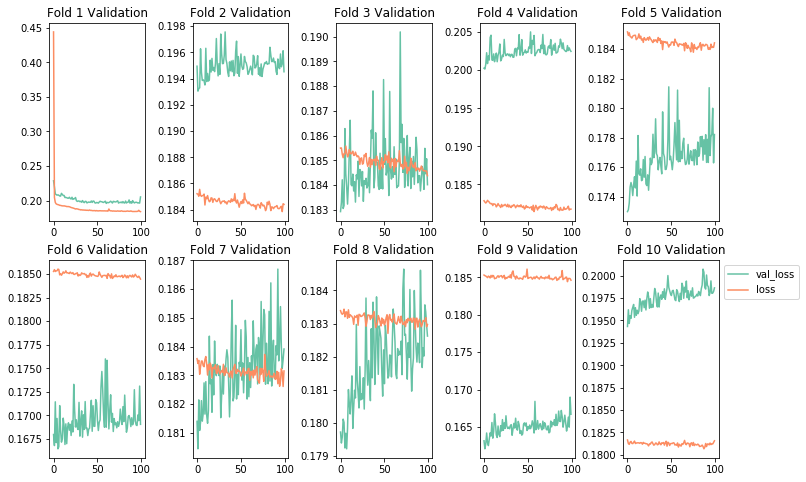

In [9]:
#Your code here; use your k-folds function to evaluate the baseline model.

now = datetime.datetime.now()

k_folds(X_train, y_train, model)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)


## Intentionally Overfitting a Model

Now that you've developed a baseline model, its time to intentionally overfit a model. To overfit a model, you can:
* Add layers
* Make the layers bigger
* Increase the number of training epochs

Again, be careful here. Think about the limitations of your resources, both in terms of your computers specs and how much time and patience you have to let the process run. Also keep in mind that you will then be regularizing these overfit models, meaning another round of experiments and more time and resources.  

For example, here are some timing notes on potential experiments run on a Macbook Pro 3.1 GHz Intel Core i5 with 16gb of RAM:

* Using our 10 fold cross validation methodology, a 5-layer neural network with 10 units per hidden layer and 100 epochs took approximately 15 minutes to train and validate  

* Using our 10 fold cross validation methodology, a 5-layer neural network with 25 units per hidden layer and 100 epochs took approximately 25 minutes to train and validate  

* Using our 10 fold cross validation methodology, a 5-layer neural network with 10 units per hidden layer and 250 epochs took approximately 45 minutes to train and validate


3725/3725 [==============================] - 0s 11us/step
Mean Validation Score: 0.1862777501572407
Standard Deviation of Validation Scores: 0.00903119126124394
Time Elapsed: 0:12:03.230600


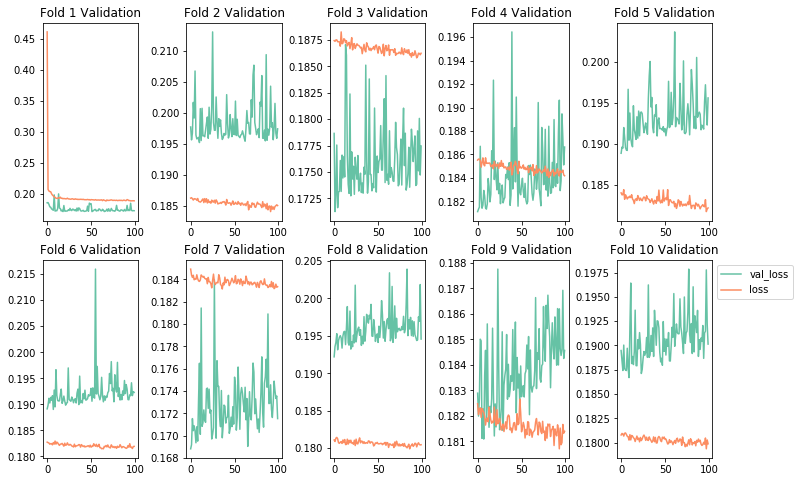

In [10]:
#Your code here; try some methods to overfit your network
#Timing Notes: On a top of the line mac-book pro, using our 10 fold cross validation methodology,
#a 5-layer neural network with 10 units per hidden layer and 100 epochs took ~15 minutes to train and validate

now = datetime.datetime.now()

#Model Mod 1: Adding More Layers
model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model)    

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3725/3725 [==============================] - 0s 11us/step
Mean Validation Score: 0.18465021129615647
Standard Deviation of Validation Scores: 0.014659462615193094
Time Elapsed: 0:12:10.937069


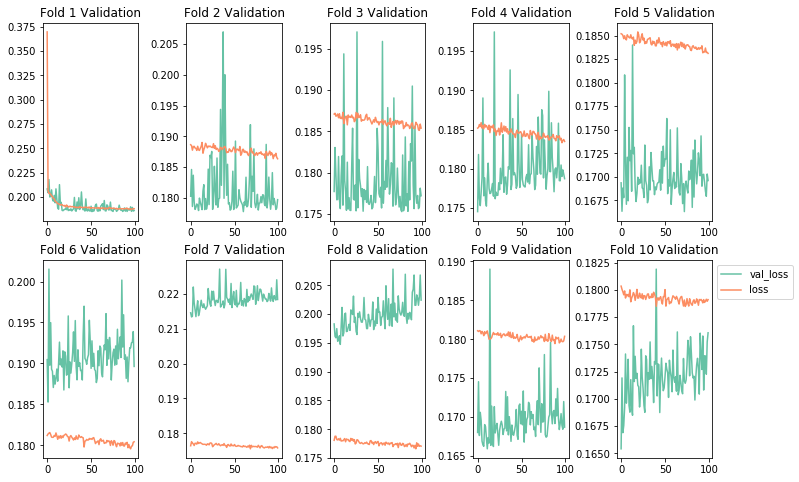

In [11]:
#Your code here; try some methods to overfit your network
#Timing Notes: On a top of the line mac-book pro, using our 10 fold cross validation methodology,
#a 5-layer neural network with 25 units per hidden layer and 100 epochs took ~25 minutes to train and validate

now = datetime.datetime.now()

model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model)    

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3725/3725 [==============================] - 0s 16us/step
Mean Validation Score: 0.18542126745319046
Standard Deviation of Validation Scores: 0.010729811446355405
Time Elapsed: 0:40:14.388388


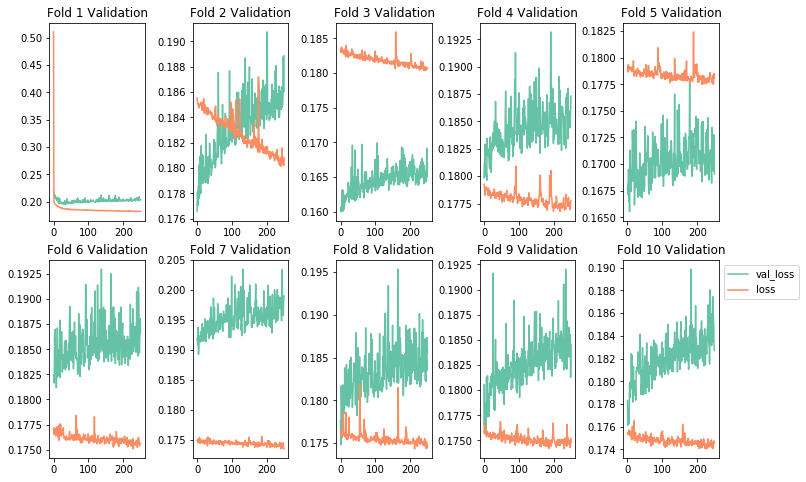

In [12]:
#Your code here; try some methods to overfit your network
#Model Mod 3: More Layers, More Epochs 
#Timing Notes: On a top of the line mac-book pro, using our 10 fold cross validation methodology,
#a 5-layer neural network with 10 units per hidden layer and 250 epochs took ~45 minutes to train and validate

now = datetime.datetime.now()

model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=250)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

## Regularizing the Model to Achieve Balance  

Now that you have a powerful model (albeit an overfit one), we can now increase the generalization of the model by using some of the regularization techniques we discussed. Some options you have to try include:  
* Adding dropout
* Adding L1/L2 regularization
* Altering the layer architecture (add or remove layers similar to above)  

This process will be constrained by time and resources. Be sure to test at least 2 different methodologies, such as dropout and L2 regularization. If you have the time, feel free to continue experimenting.

Notes: 

3725/3725 [==============================] - 0s 13us/step
Mean Validation Score: 0.19961830414287457
Standard Deviation of Validation Scores: 0.0142184398372506
Time Elapsed: 0:33:48.149439


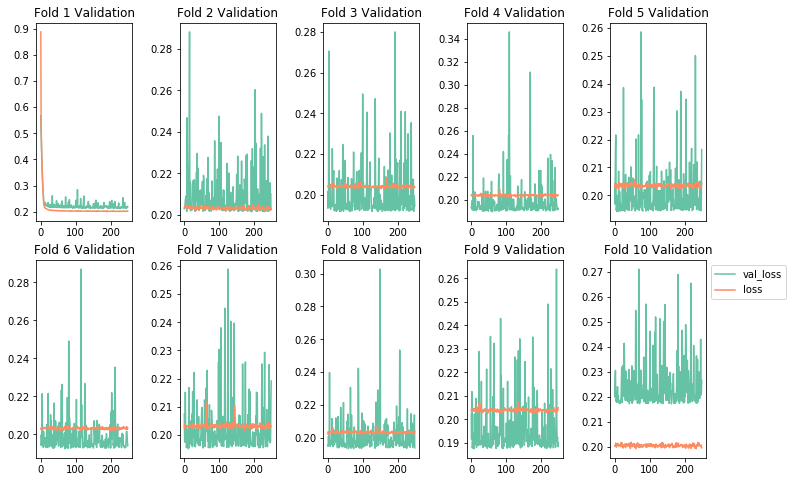

In [13]:
#Your code here; try some regularization or other methods to tune your network

#L1 Regularization


#kernel_regularizer=regularizers.l1(0.005)
#kernel_regularizer=regularizers.l2(0.005)
#model.add(layers.Dropout(0.3))

now = datetime.datetime.now()


model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=250) 

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3725/3725 [==============================] - 0s 12us/step
Mean Validation Score: 0.19602930410063557
Standard Deviation of Validation Scores: 0.010028863410306248
Time Elapsed: 0:09:59.013554


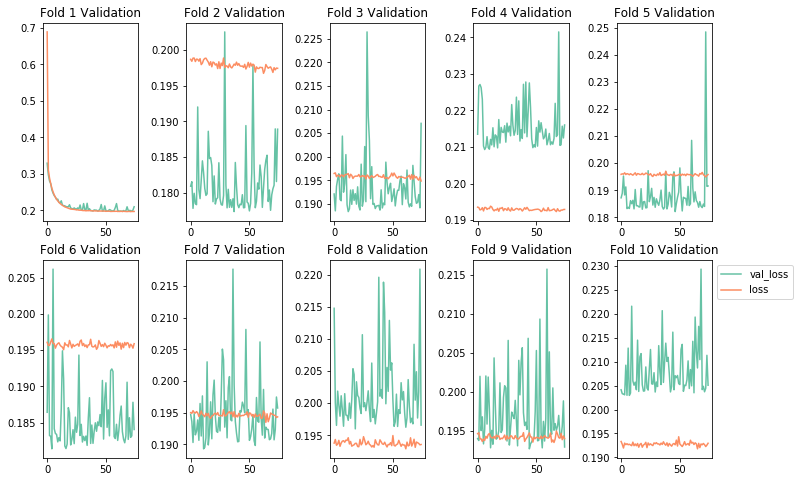

In [14]:
#Your code here; try some regularization or other methods to tune your network
#L2 Regularization and Early Stopping
now = datetime.datetime.now()


model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=75) 

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3725/3725 [==============================] - 0s 18us/step
Mean Validation Score: 0.2661841392323507
Standard Deviation of Validation Scores: 0.021751080349936027
Time Elapsed: 0:11:31.279791


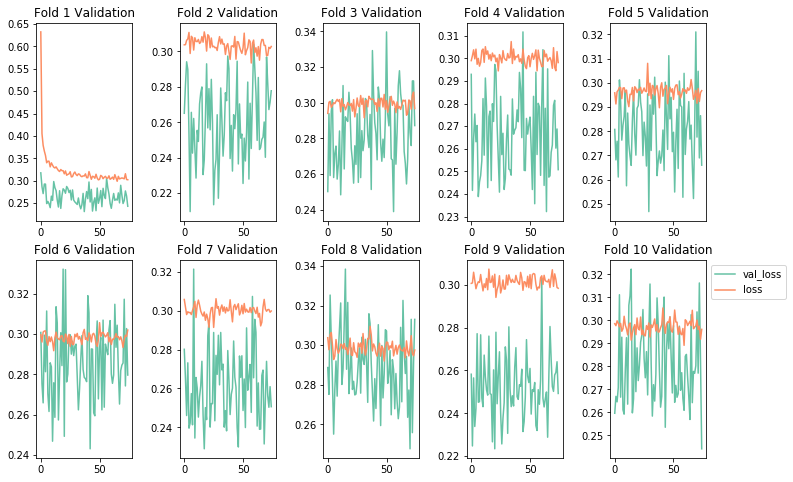

In [15]:
#Your code here; try some regularization or other methods to tune your network
#Dropout and Early Stopping

now = datetime.datetime.now()


model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=75) 

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3725/3725 [==============================] - 0s 14us/step
Mean Validation Score: 0.2692864800271502
Standard Deviation of Validation Scores: 0.028976360713082752
Time Elapsed: 0:12:02.615164


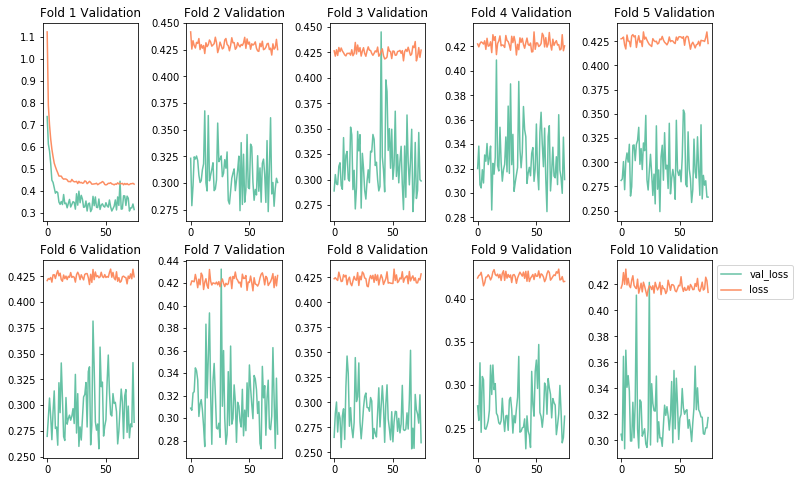

In [16]:
#Your code here; try some regularization or other methods to tune your network
#L1, Dropout and Early Stopping

now = datetime.datetime.now()


model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=75) 

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

In [ ]:
# run the entire notebook again at this point if I want to calculate the total time for all of these models to run

end = datetime.datetime.now()
elapsed = end - start
print('Total Time Elapsed:', elapsed)

## Final Evaluation

Now that you have selected a network architecture, tested various regularization procedures and tuned hyperparameters via a validation methodology, it is time to evaluate your finalized model once and for all. Fit the model using all of the training and validation data using the architecture and hyperparameters that were most effective in your expirements above. Afterwards, measure the overall performance on the hold-out test data which has been left untouched (and hasn't leaked any data into the modelling process)!

In [17]:

#Your code here; final model training on entire training set followed by evaluation on hold-out data

#Based on our model runs above, it appears that using  L2 Regularization and Early Stopping
#improves our variance 10 fold in exchange for a slight increase in MSE
#As such, we will choose this as our final model in hopes that the model will have improved generalization
now = datetime.datetime.now()


model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

hist =  hist = model.fit(X_train, y_train, batch_size=32, epochs=75)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

Epoch 1/75
37254/37254 [==============================] - 1s 34us/step - loss: 0.4300 - mean_squared_error: 0.3024
Epoch 2/75
37254/37254 [==============================] - 1s 25us/step - loss: 0.3082 - mean_squared_error: 0.2051
Epoch 3/75
37254/37254 [==============================] - 1s 25us/step - loss: 0.2867 - mean_squared_error: 0.2035
Epoch 4/75
37254/37254 [==============================] - 1s 25us/step - loss: 0.2709 - mean_squared_error: 0.2034
Epoch 5/75
37254/37254 [==============================] - 1s 24us/step - loss: 0.2571 - mean_squared_error: 0.2018
Epoch 6/75
37254/37254 [==============================] - 1s 24us/step - loss: 0.2484 - mean_squared_error: 0.2029
Epoch 7/75
37254/37254 [==============================] - 1s 24us/step - loss: 0.2401 - mean_squared_error: 0.2022
Epoch 8/75
37254/37254 [==============================] - 1s 25us/step - loss: 0.2339 - mean_squared_error: 0.2021
Epoch 9/75
37254/37254 [==============================] - 1s 25us/step - loss: 0

37254/37254 [==============================] - 1s 24us/step - loss: 0.2000 - mean_squared_error: 0.1934
Epoch 72/75
37254/37254 [==============================] - 1s 24us/step - loss: 0.1995 - mean_squared_error: 0.1929
Epoch 73/75
37254/37254 [==============================] - 1s 24us/step - loss: 0.1996 - mean_squared_error: 0.1931
Epoch 74/75
37254/37254 [==============================] - 1s 25us/step - loss: 0.2003 - mean_squared_error: 0.1937
Epoch 75/75
37254/37254 [==============================] - 1s 25us/step - loss: 0.1993 - mean_squared_error: 0.1928
Time Elapsed: 0:01:09.316534


In [18]:
model.evaluate(X_test, y_test)

4140/4140 [==============================] - 0s 32us/step


[0.235339300442433, 0.22818123093549755]

## Additional Resources

https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
https://www.springboard.com/blog/free-public-data-sets-data-science-project/

## Summary

In this lab, we investigated some data from *The Lending Club* in a complete data science pipeline regarding neural networks. We began with reserving a hold-out set for testing which never was touched during the modeling phase. From there, we implemented a k-fold cross validation methodology in order to assess an initial baseline model and various regularization methods. From here, we'll begin to investigate other neural network architectures such as CNNs.